# 1. Building a neural network model in TensorFlow
## Basic imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## 1. Building a linear regression model
### 1. Create a toy dataset in NumPy and visualize it

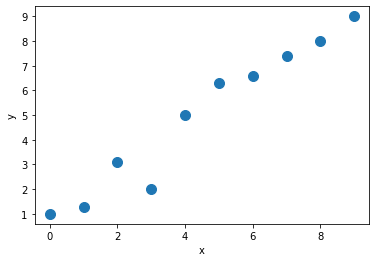

In [2]:
X_train = np.arange(10).reshape((10, 1))
y_train = np.array([1.0, 1.3, 3.1,
                    2.0, 5.0, 6.3,
                    6.6, 7.4, 8.0,
                    9.0])


plt.plot(X_train, y_train, 'o', markersize=10)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### 2. Standardize the features and create a TensorFlow Dataset

In [3]:
X_train_norm = (X_train - np.mean(X_train))/np.std(X_train)

ds_train_orig = tf.data.Dataset.from_tensor_slices(
    (tf.cast(X_train_norm, tf.float32),
     tf.cast(y_train, tf.float32)))

### 3. Define a new class derived from the tf.keras.Model class
- Subclassing tf.keras.Model allows us to use the Keras tools for exploring a model, training, and evaluation
- In the construction of our class, we will define the parameters of our model, w and b, which correspond to the weight and the bias parameters, respectively
- Finally, we will define the call() method to determine how this model uses the input data to generate output

In [5]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.w = tf.Variable(0.0, name='weight')
        self.b = tf.Variable(0.0, name='bias')

    def call(self, x):
        return self.w*x + self.b

### 4. Instantiate a new model from the MyModel() class
- The Keras API method .summary() allows us to get a summary of the model components layer by layer and the number of parameters in each layer
- Before calling .summary() we have to specify the dimensionality of the input (the number of features) to this model by calling model.build() with the expected shape of the input data
- Using None as a placeholder for the first dimension of the expected input tensor allows us to use an arbitrary batch size
- However, the number of features is fixed (here 1) as it directly corresponds to the number of weight parameters of the model

In [6]:
model = MyModel()

model.build(input_shape=(None, 1))
model.summary()

Model: "my_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


### 5. Define the cost function
- We choose mean squared error (MSE)

In [7]:
def loss_fn(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))


## testing the function:
yt = tf.convert_to_tensor([1.0])
yp = tf.convert_to_tensor([1.5])

loss_fn(yt, yp)

<tf.Tensor: id=55, shape=(), dtype=float32, numpy=0.25>

### 6. Implement the stochastic gradient descent procedure
- We could use the Keras methods to do the same things, but for now we do it manually
- Rather than manually computing the gradients, we use the TensroFlow API tg.GradientTape

In [8]:
def train(model, inputs, outputs, learning_rate):
    with tf.GradientTape() as tape:
        current_loss = loss_fn(model(inputs), outputs)
    dW, db = tape.gradient(current_loss, [model.w, model.b])
    model.w.assign_sub(learning_rate * dW)
    model.b.assign_sub(learning_rate * db)

### 7. Set the hyperparameters and train the model for 200 epochs
- We create a batched version of the dataset and repeat the dataset with count=None, which results in an infinitely repeated dataset

In [9]:
tf.random.set_seed(1)

num_epochs = 200
log_steps = 100
learning_rate = 0.001
batch_size = 1
steps_per_epoch = int(np.ceil(len(y_train) / batch_size))


ds_train = ds_train_orig.shuffle(buffer_size=len(y_train))
ds_train = ds_train.repeat(count=None)
ds_train = ds_train.batch(1)

Ws, bs = [], []

for i, batch in enumerate(ds_train):
    if i >= steps_per_epoch * num_epochs:
        break
    Ws.append(model.w.numpy())
    bs.append(model.b.numpy())

    bx, by = batch
    loss_val = loss_fn(model(bx), by)

    train(model, bx, by, learning_rate=learning_rate)
    if i%log_steps==0:
        print('Epoch {:4d} Step {:2d} Loss {:6.4f}'.format(
              int(i/steps_per_epoch), i, loss_val))

Epoch    0 Step  0 Loss 43.5600
Epoch   10 Step 100 Loss 0.7530
Epoch   20 Step 200 Loss 20.1759
Epoch   30 Step 300 Loss 23.3976
Epoch   40 Step 400 Loss 6.3481
Epoch   50 Step 500 Loss 4.6356
Epoch   60 Step 600 Loss 0.2411
Epoch   70 Step 700 Loss 0.2036
Epoch   80 Step 800 Loss 3.8177
Epoch   90 Step 900 Loss 0.9416
Epoch  100 Step 1000 Loss 0.7035
Epoch  110 Step 1100 Loss 0.0348
Epoch  120 Step 1200 Loss 0.5404
Epoch  130 Step 1300 Loss 0.1170
Epoch  140 Step 1400 Loss 0.1195
Epoch  150 Step 1500 Loss 0.0944
Epoch  160 Step 1600 Loss 0.4670
Epoch  170 Step 1700 Loss 2.0695
Epoch  180 Step 1800 Loss 0.0020
Epoch  190 Step 1900 Loss 0.3612


### 8. Plot the trained model and the convergence history of the weight and the bias unit

Final Parameters: 2.6576622 4.8798566


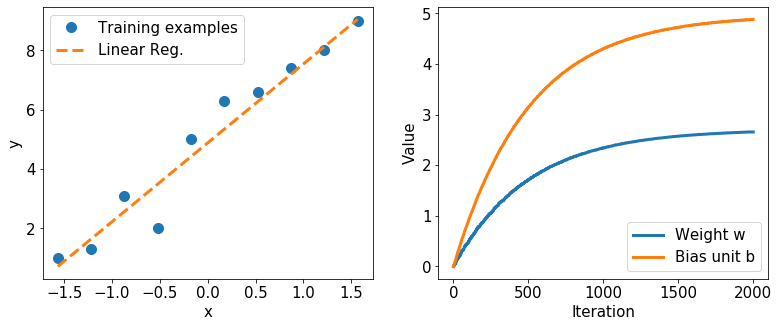

In [10]:
print('Final Parameters:', model.w.numpy(), model.b.numpy())

X_test = np.linspace(0, 9, num=100).reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)

y_pred = model(tf.cast(X_test_norm, dtype=tf.float32))


fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.plot(X_test_norm, y_pred, '--', lw=3)
plt.legend(['Training examples', 'Linear Reg.'], fontsize=15)
ax.set_xlabel('x', size=15)
ax.set_ylabel('y', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(Ws, lw=3)
plt.plot(bs, lw=3)
plt.legend(['Weight w', 'Bias unit b'], fontsize=15)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Value', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()